In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit, njit, prange, set_num_threads

In [2]:

@njit(parallel=True)
def G_Force(m, Xi,Xj,Yi,Yj,Zi,Zj, G=1, r_soft=0.01):
    
    Xij = Xj - Xi
    Yij = Yj - Yi
    Zij = Zj - Zi
    
    R = np.sqrt(Xij**2+Yij**2+Zij**2)
    F = G*m**2/(R+r_soft)**3
    U = -F*R**2
    
    Fx = F*Xij
    Fy = F*Yij
    Fz = F*Zij
    
    Fx_total = np.sum(Fx, axis=1)
    Fy_total = np.sum(Fy, axis=1)
    Fz_total = np.sum(Fz, axis=1)
    
    return Fx_total, Fy_total, Fz_total, U


In [3]:
#some test

#mac outer
37.166444063186646 #N=10000 no jit
12.239506006240845 #N=10000 with jit
#12900k outer
8.607457876205444 #N=10000 no jit
8.322943449020386 #N=10000 with jit
#12900k meshgrid
7.489137887954712 #N=10000 no jit
6.85585355758667  #N=10000 with jit
#12900k meshgrid outside def
5.434570550918579 #N=10000 with jit first
#12900k meshgrid outside def
4.00260066986084 #N=10000 with njit(parallel=True)

4.00260066986084

In [4]:
3.4647891521453857 #first
2.6609530448913574 #second

2.6609530448913574

# Euler

In [5]:
N = 1000
m = 20/N
np.random.seed(111022544)
pos = np.random.randn(N,3)
np.random.seed(111022544)
vel = np.random.randn(N,3)
np.random.seed(111022544)
acc = np.random.randn(N,3)
np.random.seed(111022544)
acc2 = np.random.randn(N,3)

dt = 0.01
tmax = 10
T = np.linspace(0,tmax,int(tmax/dt)+1)

sol_pos = np.zeros((N,3,len(T)))
sol_vel = np.zeros((N,3,len(T)))
U_Euler = np.zeros(len(T))
K_Euler = np.zeros(len(T))

t_start = time.time()

for i,t in enumerate(T):
    
    if i == 0:
        
        sol_pos[:,:,i] = pos
        sol_vel[:,:,i] = vel
        
        K_Euler[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        U_Euler[i] = np.sum(U_tensor)/2
        
    else:
        s = time.time()
        
        pos = sol_pos[:,:,i-1]
        vel = sol_vel[:,:,i-1]
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc[:,0] = ax
        acc[:,1] = ay
        acc[:,2] = az
        
        next_pos = pos + vel*dt
        next_vel = vel + acc*dt
        
        sol_pos[:,:,i] = next_pos
        sol_vel[:,:,i] = next_vel
        
        K_Euler[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        U_Euler[i] = np.sum(U_tensor)/2
        
        e = time.time()
        if i%100 == 0:
            print('time:',t,', spend:',e-s)

E_Euler = K_Euler +U_Euler

t_end = time.time()
print('total time',t_end-t_start)

time: 1.0 , spend: 0.015946388244628906
time: 2.0 , spend: 0.015946626663208008
time: 3.0 , spend: 0.015945911407470703
time: 4.0 , spend: 0.01594686508178711
time: 5.0 , spend: 0.014949321746826172
time: 6.0 , spend: 0.01594710350036621
time: 7.0 , spend: 0.01495051383972168
time: 8.0 , spend: 0.014950037002563477
time: 9.0 , spend: 0.015946388244628906
time: 10.0 , spend: 0.015946388244628906
total time 16.922380924224854


C:\Users\alan\anaconda3\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


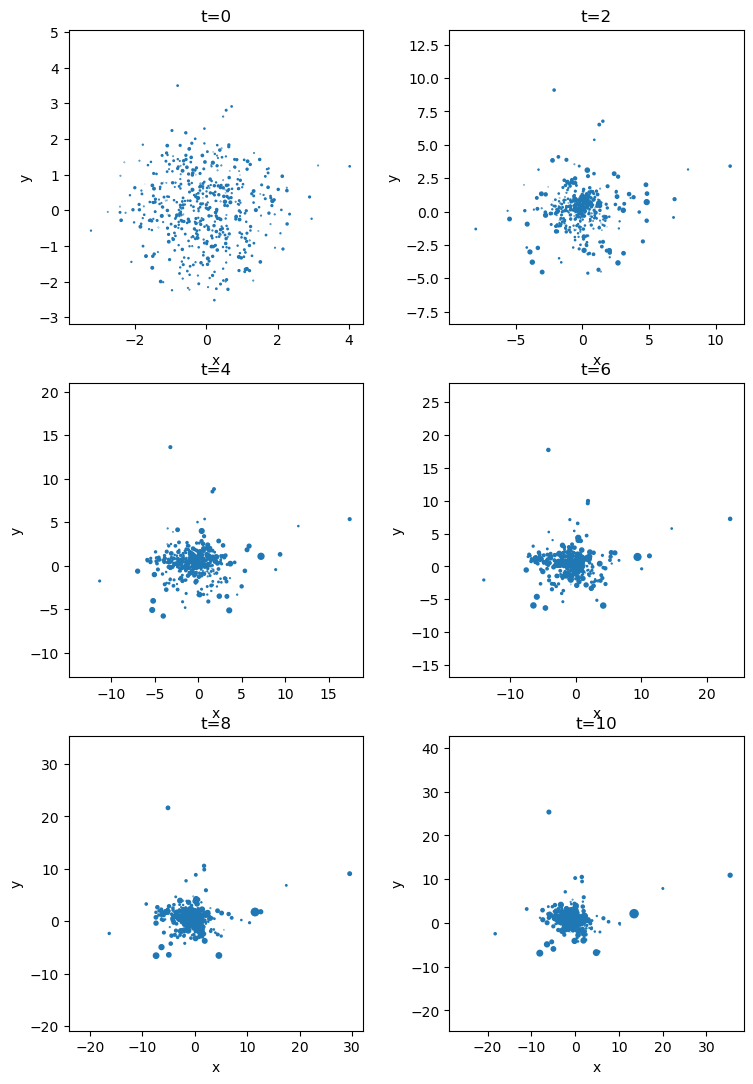

In [6]:
x1 = sol_pos[:,0,0]
y1 = sol_pos[:,1,0]
z1 = sol_pos[:,2,0]

x2 = sol_pos[:,0,200]
y2 = sol_pos[:,1,200]
z2 = sol_pos[:,2,200]

x3 = sol_pos[:,0,400]
y3 = sol_pos[:,1,400]
z3 = sol_pos[:,2,400]

x4 = sol_pos[:,0,600]
y4 = sol_pos[:,1,600]
z4 = sol_pos[:,2,600]

x5 = sol_pos[:,0,800]
y5 = sol_pos[:,1,800]
z5 = sol_pos[:,2,800]

x6 = sol_pos[:,0,1000]
y6 = sol_pos[:,1,1000]
z6 = sol_pos[:,2,1000]

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(9, 13))

ax[0,0].scatter(x1, y1, 1.5*z1)
ax[0,0].set_title('t=0')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')
ax[0,0].axis('square')

ax[0,1].scatter(x2, y2, 1.5*z2)
ax[0,1].set_title('t=2')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')
ax[0,1].axis('square')

ax[1,0].scatter(x3, y3, 1.5*z3)
ax[1,0].set_title('t=4')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].axis('square')

ax[1,1].scatter(x4, y4, 1.5*z4)
ax[1,1].set_title('t=6')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('y')
ax[1,1].axis('square')

ax[2,0].scatter(x5, y5, 1.5*z5)
ax[2,0].set_title('t=8')
ax[2,0].set_xlabel('x')
ax[2,0].set_ylabel('y')
ax[2,0].axis('square')

ax[2,1].scatter(x6, y6, 1.5*z6)
ax[2,1].set_title('t=10')
ax[2,1].set_xlabel('x')
ax[2,1].set_ylabel('y')
ax[2,1].axis('square')

plt.savefig('P1_Euler.png')

# RK2

In [7]:
N = 1000
m = 20/N
np.random.seed(111022544)
pos = np.random.randn(N,3)
np.random.seed(111022544)
vel = np.random.randn(N,3)
np.random.seed(111022544)
acc = np.random.randn(N,3)
np.random.seed(111022544)
acc2 = np.random.randn(N,3)

dt = 0.01
tmax = 10
T = np.linspace(0,tmax,int(tmax/dt)+1)

sol_pos = np.zeros((N,3,len(T)))
sol_vel = np.zeros((N,3,len(T)))
U_RK2 = np.zeros(len(T))
K_RK2 = np.zeros(len(T))

t_start = time.time()

for i,t in enumerate(T):
    
    if i == 0:
        
        sol_pos[:,:,i] = pos
        sol_vel[:,:,i] = vel
        
        K_RK2[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        U_RK2[i] = np.sum(U_tensor)/2
        
    else:
        s = time.time()
        
        pos = sol_pos[:,:,i-1]
        vel = sol_vel[:,:,i-1]
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc[:,0] = ax
        acc[:,1] = ay
        acc[:,2] = az
        
        pos2 = pos + vel*dt
        vel2 = vel + acc*dt
        
        Xi,Xj = np.meshgrid(pos2[:,0], pos2[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos2[:,1], pos2[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos2[:,2], pos2[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc2[:,0] = ax
        acc2[:,1] = ay
        acc2[:,2] = az
        
        next_pos = pos + dt/2*(vel + vel2)
        next_vel = vel + dt/2*(acc + acc2)
        
        sol_pos[:,:,i] = next_pos
        sol_vel[:,:,i] = next_vel
        
        K_RK2[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        U_RK2[i] = np.sum(U_tensor)/2
        
        e = time.time()
        if i%100 == 0:
            print('time:',t,', spend:',e-s)

E_RK2 = K_RK2 +U_RK2

t_end = time.time()
print('total time',t_end-t_start)


time: 1.0 , spend: 0.029900074005126953
time: 2.0 , spend: 0.030896902084350586
time: 3.0 , spend: 0.02989983558654785
time: 4.0 , spend: 0.029900312423706055
time: 5.0 , spend: 0.02989935874938965
time: 6.0 , spend: 0.029938459396362305
time: 7.0 , spend: 0.02890300750732422
time: 8.0 , spend: 0.029900312423706055
time: 9.0 , spend: 0.02989959716796875
time: 10.0 , spend: 0.02989983558654785
total time 29.850383043289185


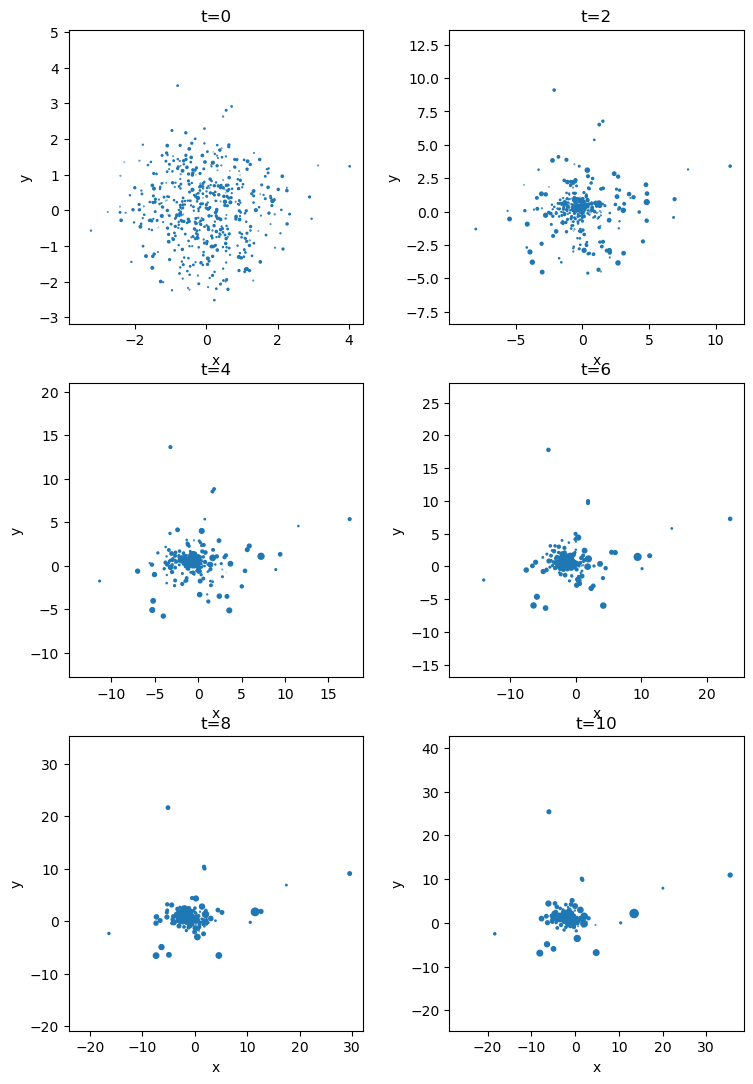

In [8]:
x1 = sol_pos[:,0,0]
y1 = sol_pos[:,1,0]
z1 = sol_pos[:,2,0]

x2 = sol_pos[:,0,200]
y2 = sol_pos[:,1,200]
z2 = sol_pos[:,2,200]

x3 = sol_pos[:,0,400]
y3 = sol_pos[:,1,400]
z3 = sol_pos[:,2,400]

x4 = sol_pos[:,0,600]
y4 = sol_pos[:,1,600]
z4 = sol_pos[:,2,600]

x5 = sol_pos[:,0,800]
y5 = sol_pos[:,1,800]
z5 = sol_pos[:,2,800]

x6 = sol_pos[:,0,1000]
y6 = sol_pos[:,1,1000]
z6 = sol_pos[:,2,1000]

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(9, 13))

ax[0,0].scatter(x1, y1, 1.5*z1)
ax[0,0].set_title('t=0')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')
ax[0,0].axis('square')

ax[0,1].scatter(x2, y2, 1.5*z2)
ax[0,1].set_title('t=2')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')
ax[0,1].axis('square')

ax[1,0].scatter(x3, y3, 1.5*z3)
ax[1,0].set_title('t=4')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].axis('square')

ax[1,1].scatter(x4, y4, 1.5*z4)
ax[1,1].set_title('t=6')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('y')
ax[1,1].axis('square')

ax[2,0].scatter(x5, y5, 1.5*z5)
ax[2,0].set_title('t=8')
ax[2,0].set_xlabel('x')
ax[2,0].set_ylabel('y')
ax[2,0].axis('square')

ax[2,1].scatter(x6, y6, 1.5*z6)
ax[2,1].set_title('t=10')
ax[2,1].set_xlabel('x')
ax[2,1].set_ylabel('y')
ax[2,1].axis('square')

plt.savefig('P1_RK2.png')

# RK4

In [9]:
N = 1000
m = 20/N
np.random.seed(111022544)
pos = np.random.randn(N,3)
np.random.seed(111022544)
vel = np.random.randn(N,3)
np.random.seed(111022544)
acc1 = np.random.randn(N,3)
np.random.seed(111022544)
acc2 = np.random.randn(N,3)
np.random.seed(111022544)
acc3 = np.random.randn(N,3)
np.random.seed(111022544)
acc4 = np.random.randn(N,3)

dt = 0.01
tmax = 10
T = np.linspace(0,tmax,int(tmax/dt)+1)

sol_pos = np.zeros((N,3,len(T)))
sol_vel = np.zeros((N,3,len(T)))
U_RK4 = np.zeros(len(T))
K_RK4 = np.zeros(len(T))

t_start = time.time()

for i,t in enumerate(T):
    
    if i == 0:
        
        sol_pos[:,:,i] = pos
        sol_vel[:,:,i] = vel
        
        K_RK4[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        U_RK4[i] = np.sum(U_tensor)/2
        
    else:
        s = time.time()
        
        pos1 = sol_pos[:,:,i-1]
        vel1 = sol_vel[:,:,i-1]
        
        Xi,Xj = np.meshgrid(pos1[:,0], pos1[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos1[:,1], pos1[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos1[:,2], pos1[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc1[:,0] = ax
        acc1[:,1] = ay
        acc1[:,2] = az
        
        pos2 = pos1 + 0.5*vel1*dt
        vel2 = vel1 + 0.5*acc1*dt
        
        Xi,Xj = np.meshgrid(pos2[:,0], pos2[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos2[:,1], pos2[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos2[:,2], pos2[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc2[:,0] = ax
        acc2[:,1] = ay
        acc2[:,2] = az
        
        pos3 = pos1 + 0.5*vel2*dt
        vel3 = vel1 + 0.5*acc2*dt
        
        Xi,Xj = np.meshgrid(pos3[:,0], pos3[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos3[:,1], pos3[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos3[:,2], pos3[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc3[:,0] = ax
        acc3[:,1] = ay
        acc3[:,2] = az
        
        pos4 = pos1 + vel3*dt
        vel4 = vel1 + acc3*dt
        
        Xi,Xj = np.meshgrid(pos4[:,0], pos4[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos4[:,1], pos4[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos4[:,2], pos4[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc4[:,0] = ax
        acc4[:,1] = ay
        acc4[:,2] = az
        
        next_pos = pos1 + dt/6*(vel1 + 2*vel2 + 2*vel3 + vel4)
        next_vel = vel1 + dt/6*(acc1 + 2*acc2 + 2*acc3 + acc4)
        
        sol_pos[:,:,i] = next_pos
        sol_vel[:,:,i] = next_vel
        
        K_RK4[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        U_RK4[i] = np.sum(U_tensor)/2
        
        e = time.time()
        if i%100 == 0:
            print('time:',t,', spend:',e-s)

E_RK4 = K_RK4 +U_RK4

t_end = time.time()
print('total time',t_end-t_start)


time: 1.0 , spend: 0.05980038642883301
time: 2.0 , spend: 0.05880308151245117
time: 3.0 , spend: 0.05880331993103027
time: 4.0 , spend: 0.0597996711730957
time: 5.0 , spend: 0.058803558349609375
time: 6.0 , spend: 0.058804988861083984
time: 7.0 , spend: 0.057807207107543945
time: 8.0 , spend: 0.0597996711730957
time: 9.0 , spend: 0.05780673027038574
time: 10.0 , spend: 0.05780649185180664
total time 58.801976680755615


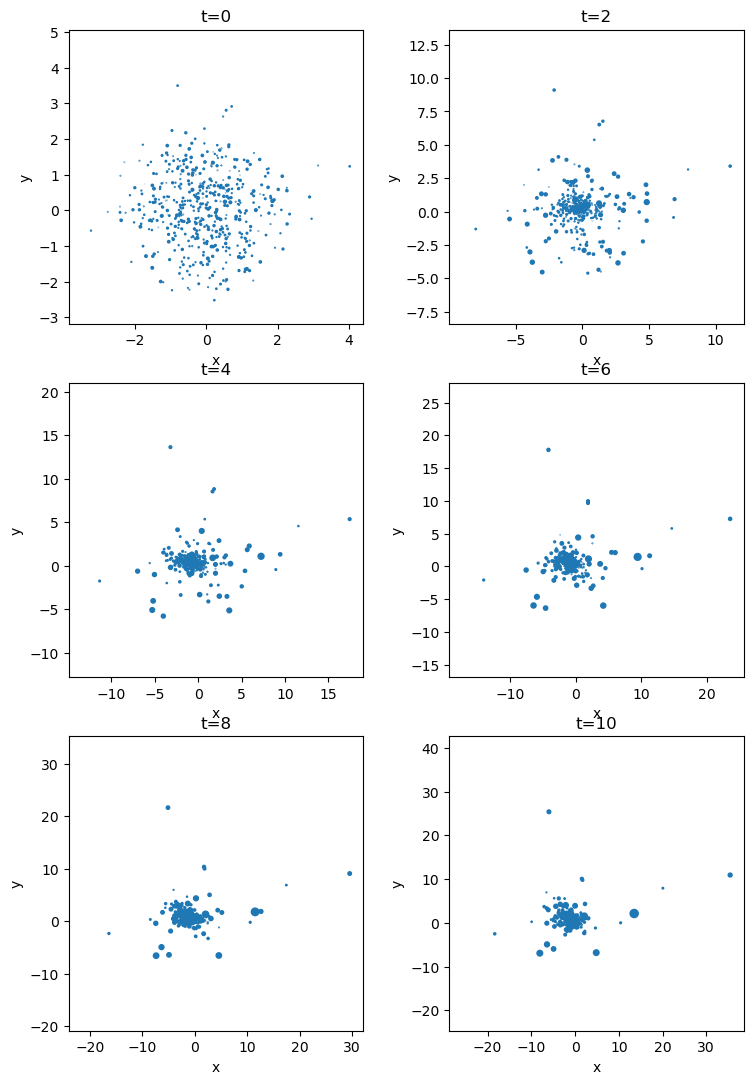

In [10]:
x1 = sol_pos[:,0,0]
y1 = sol_pos[:,1,0]
z1 = sol_pos[:,2,0]

x2 = sol_pos[:,0,200]
y2 = sol_pos[:,1,200]
z2 = sol_pos[:,2,200]

x3 = sol_pos[:,0,400]
y3 = sol_pos[:,1,400]
z3 = sol_pos[:,2,400]

x4 = sol_pos[:,0,600]
y4 = sol_pos[:,1,600]
z4 = sol_pos[:,2,600]

x5 = sol_pos[:,0,800]
y5 = sol_pos[:,1,800]
z5 = sol_pos[:,2,800]

x6 = sol_pos[:,0,1000]
y6 = sol_pos[:,1,1000]
z6 = sol_pos[:,2,1000]

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(9, 13))

ax[0,0].scatter(x1, y1, 1.5*z1)
ax[0,0].set_title('t=0')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')
ax[0,0].axis('square')

ax[0,1].scatter(x2, y2, 1.5*z2)
ax[0,1].set_title('t=2')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')
ax[0,1].axis('square')

ax[1,0].scatter(x3, y3, 1.5*z3)
ax[1,0].set_title('t=4')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].axis('square')

ax[1,1].scatter(x4, y4, 1.5*z4)
ax[1,1].set_title('t=6')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('y')
ax[1,1].axis('square')

ax[2,0].scatter(x5, y5, 1.5*z5)
ax[2,0].set_title('t=8')
ax[2,0].set_xlabel('x')
ax[2,0].set_ylabel('y')
ax[2,0].axis('square')

ax[2,1].scatter(x6, y6, 1.5*z6)
ax[2,1].set_title('t=10')
ax[2,1].set_xlabel('x')
ax[2,1].set_ylabel('y')
ax[2,1].axis('square')

plt.savefig('P1_RK4.png')

# Leap-frog scheme

In [11]:
N = 1000
m = 20/N
np.random.seed(111022544)
pos = np.random.randn(N,3)
np.random.seed(111022544)
vel = np.random.randn(N,3)
np.random.seed(111022544)
acc = np.random.randn(N,3)
np.random.seed(111022544)
acc2 = np.random.randn(N,3)

dt = 0.01
tmax = 10
T = np.linspace(0,tmax,int(tmax/dt)+1)

sol_pos = np.zeros((N,3,len(T)))
sol_vel = np.zeros((N,3,len(T)))
U_LF = np.zeros(len(T))
K_LF = np.zeros(len(T))

t_start = time.time()

for i,t in enumerate(T):
    
    if i == 0:
        
        sol_pos[:,:,i] = pos
        sol_vel[:,:,i] = vel
        
        K_LF[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        U_LF[i] = np.sum(U_tensor)/2
        
    else:
        s = time.time()
        
        pos = sol_pos[:,:,i-1]
        vel = sol_vel[:,:,i-1]
        
        Xi,Xj = np.meshgrid(pos[:,0], pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(pos[:,1], pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(pos[:,2], pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc[:,0] = ax
        acc[:,1] = ay
        acc[:,2] = az
        
        next_pos = pos + vel*dt + 0.5*acc*dt**2
        
        Xi,Xj = np.meshgrid(next_pos[:,0], next_pos[:,0], indexing='ij')
        Yi,Yj = np.meshgrid(next_pos[:,1], next_pos[:,1], indexing='ij')
        Zi,Zj = np.meshgrid(next_pos[:,2], next_pos[:,2], indexing='ij')
        
        Fx, Fy, Fz, U_tensor = G_Force(m,Xi,Xj,Yi,Yj,Zi,Zj)
        
        ax = Fx/m
        ay = Fy/m
        az = Fz/m
        
        acc2[:,0] = ax
        acc2[:,1] = ay
        acc2[:,2] = az
        
        next_vel = vel + dt/2*(acc + acc2)
        
        sol_pos[:,:,i] = next_pos
        sol_vel[:,:,i] = next_vel
        
        K_LF[i] = np.sum(0.5*m*sol_vel[:,:,i]**2)
        U_LF[i] = np.sum(U_tensor)/2
        
        e = time.time()
        if i%100 == 0:
            print('time:',t,', spend:',e-s)

E_LF = K_LF +U_LF           

t_end = time.time()
print('total time',t_end-t_start)

time: 1.0 , spend: 0.02989983558654785
time: 2.0 , spend: 0.029900312423706055
time: 3.0 , spend: 0.02890324592590332
time: 4.0 , spend: 0.02989959716796875
time: 5.0 , spend: 0.028903722763061523
time: 6.0 , spend: 0.028903484344482422
time: 7.0 , spend: 0.02890300750732422
time: 8.0 , spend: 0.02890300750732422
time: 9.0 , spend: 0.030896902084350586
time: 10.0 , spend: 0.029898881912231445
total time 29.76608395576477


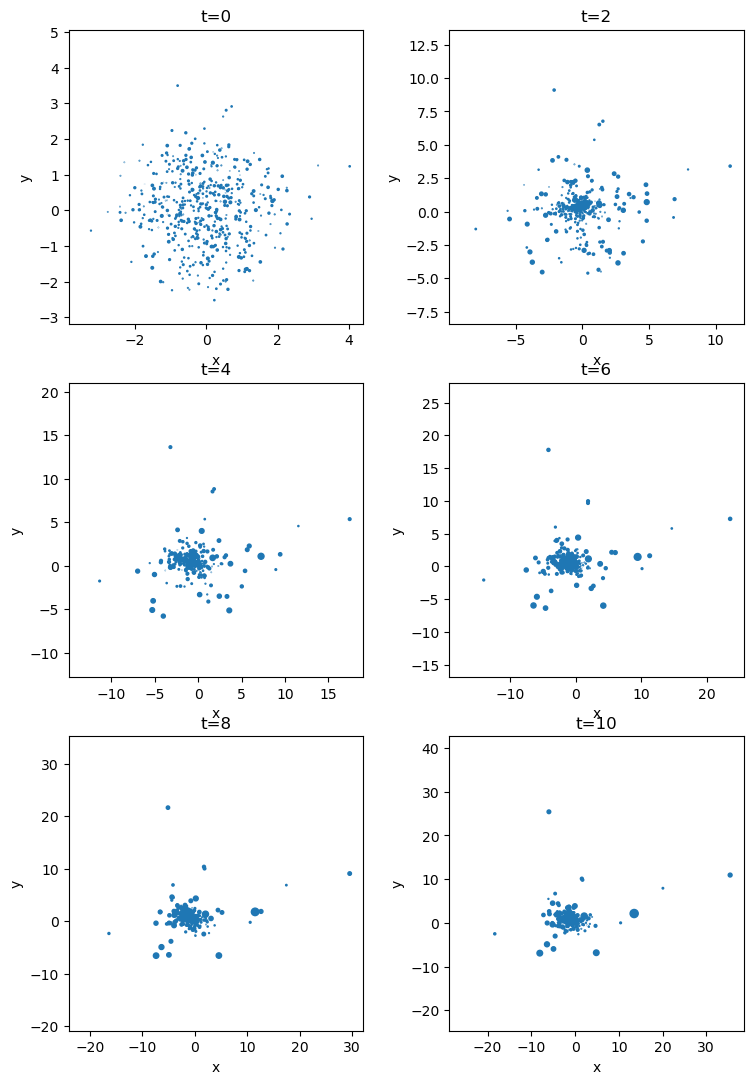

In [12]:
x1 = sol_pos[:,0,0]
y1 = sol_pos[:,1,0]
z1 = sol_pos[:,2,0]

x2 = sol_pos[:,0,200]
y2 = sol_pos[:,1,200]
z2 = sol_pos[:,2,200]

x3 = sol_pos[:,0,400]
y3 = sol_pos[:,1,400]
z3 = sol_pos[:,2,400]

x4 = sol_pos[:,0,600]
y4 = sol_pos[:,1,600]
z4 = sol_pos[:,2,600]

x5 = sol_pos[:,0,800]
y5 = sol_pos[:,1,800]
z5 = sol_pos[:,2,800]

x6 = sol_pos[:,0,1000]
y6 = sol_pos[:,1,1000]
z6 = sol_pos[:,2,1000]

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(9, 13))

ax[0,0].scatter(x1, y1, 1.5*z1)
ax[0,0].set_title('t=0')
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')
ax[0,0].axis('square')

ax[0,1].scatter(x2, y2, 1.5*z2)
ax[0,1].set_title('t=2')
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('y')
ax[0,1].axis('square')

ax[1,0].scatter(x3, y3, 1.5*z3)
ax[1,0].set_title('t=4')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].axis('square')

ax[1,1].scatter(x4, y4, 1.5*z4)
ax[1,1].set_title('t=6')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('y')
ax[1,1].axis('square')

ax[2,0].scatter(x5, y5, 1.5*z5)
ax[2,0].set_title('t=8')
ax[2,0].set_xlabel('x')
ax[2,0].set_ylabel('y')
ax[2,0].axis('square')

ax[2,1].scatter(x6, y6, 1.5*z6)
ax[2,1].set_title('t=10')
ax[2,1].set_xlabel('x')
ax[2,1].set_ylabel('y')
ax[2,1].axis('square')

plt.savefig('P2.png')

# Kinetic Energy

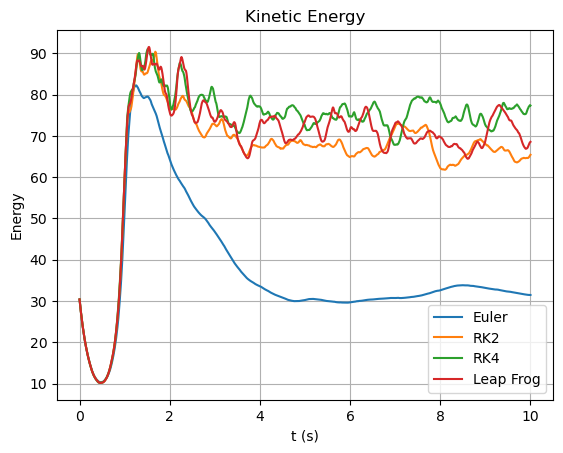

In [24]:
plt.plot(T, K_Euler, label='Euler')
plt.plot(T, K_RK2, label='RK2')
plt.plot(T, K_RK4, label='RK4')
plt.plot(T, K_LF, label='Leap Frog')

plt.title('Kinetic Energy')
plt.xlabel('t (s)')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.savefig('p3_KE');

# Potential Energy

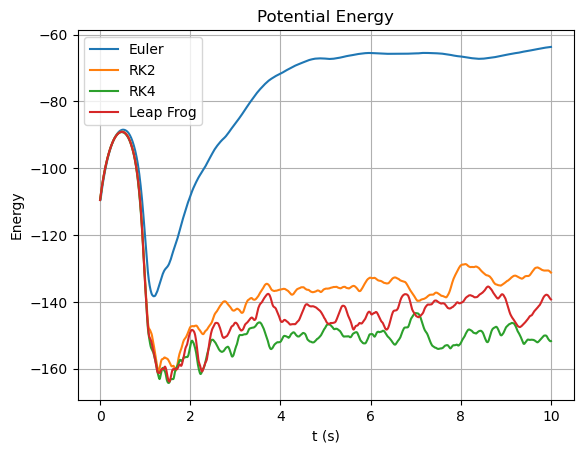

In [25]:
plt.plot(T, U_Euler, label='Euler')
plt.plot(T, U_RK2, label='RK2')
plt.plot(T, U_RK4, label='RK4')
plt.plot(T, U_LF, label='Leap Frog')

plt.title('Potential Energy')
plt.xlabel('t (s)')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.savefig('p3_UE');

# Total Energy

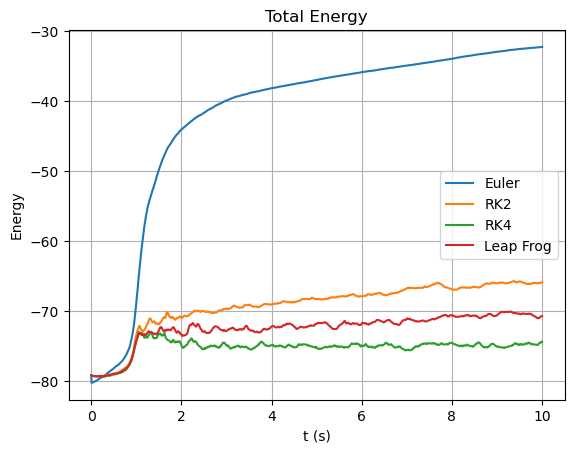

In [26]:
plt.plot(T, E_Euler, label='Euler')
plt.plot(T, E_RK2, label='RK2')
plt.plot(T, E_RK4, label='RK4')
plt.plot(T, E_LF, label='Leap Frog')

plt.title('Total Energy')
plt.xlabel('t (s)')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.savefig('p3_TE');

# Accuracy

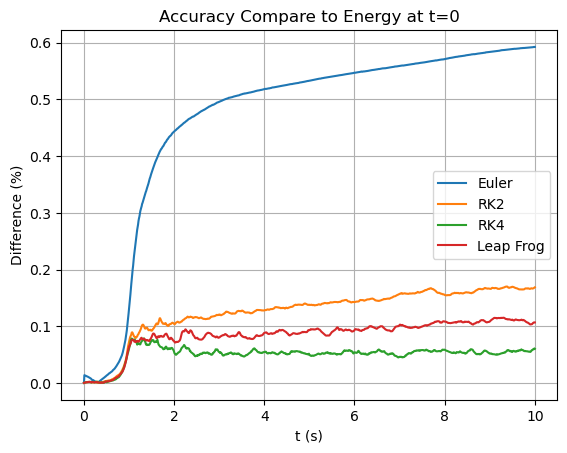

In [29]:
E_exact = E_Euler[0]

plt.plot(T, abs((E_Euler-E_exact)/E_exact), label='Euler')
plt.plot(T, abs((E_RK2-E_exact)/E_exact), label='RK2')
plt.plot(T, abs((E_RK4-E_exact)/E_exact), label='RK4')
plt.plot(T, abs((E_LF-E_exact)/E_exact), label='Leap Frog')

plt.title('Accuracy Compare to Energy at t=0')
plt.xlabel('t (s)')
plt.ylabel('Difference (%)')
plt.legend()
plt.grid()
plt.savefig('p3_Accuracy');